In [1]:

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Pad
import os
import pickle
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import seaborn as sns
from pathlib import Path

import preprocessing as pre
import visualize as vis
from models import LightningDiffusion as ld


%load_ext autoreload
%autoreload 2


/data/cb/mihirb14/mambaforge/envs/daifuku/lib/python3.9/site-packages/tqdm-4.65.0-py3.9.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/cb/mihirb14/mambaforge/envs/daifuku/lib/python3.9/site-packages/scipy-1.7.3-py3.9-linux-x86_64.egg/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_path = "/data/cb/ruochiz/scHiC/"
data_names = ["m3c_mouse_brain_small",  "m3c_Tian_et_al", "m3C_hg38_M1C_old",  "m3c_human_pfc_old", "m3c_Heffel_et_al"]
data_name = data_names[0]

dataset_path = os.path.join(data_path,data_name)
dataset_hic_path = os.path.join(dataset_path,"contact_pairs_filter")

In [22]:
# with open(os.path.join(dataset_path, "filelist.txt")) as f:
#     lines = f.readlines()
# for i, line in enumerate(lines):
#     filename = line.split("/")[-1]
#     lines[i] = dataset_path+"/contact_pairs_filter/"+filename
# with open("/data/cb/mihirb14/projects/Daifuku/data/mc3_mouse_brain_small/filelist.txt", 'w') as f2:
#     f2.writelines(lines)


In [3]:



# example_contact = np.load("/data/cb/mihirb14/projects/Daifuku/data/mc3_mouse_brain_small/contactmaps/raw/chr1_sparse_adj.npy",allow_pickle=True)
# print(example_contact.shape, example_contact[0].shape)
# contact_map = pre.spy_sparse2torch_sparse(example_contact[0]).to_dense()
# # px.imshow(contact_map,  color_continuous_scale='deep_r')

In [8]:
# import math

# pseudobulk_path = config["temp_dir"] + "bulk/"
# length = len(small_mouse_hic_dataloader)

# pseudobulk_map = np.zeros(shape=(196,196))
# for i, map in enumerate(small_mouse_hic_dataloader):
#     if i%20 == 0 and i!=0:
#         np.save(os.path.join(pseudobulk_path,str(math.ceil(i/20))), pseudobulk_map/20)
#         pseudobulk_map = np.zeros(shape=(196,196))
#     pseudobulk_map += map.numpy().squeeze()

In [3]:
# def diagonal_normalize(map):
#     normalized_map = np.zeros(map.shape)
#     for k in range(map.shape[1]):
#         diag = np.diag(map, k=k)
#         diag_sum = np.sum(diag)
#         if diag_sum != 0:
#             normalized_diag = diag/diag_sum
#             normalized_map += np.diagflat(normalized_diag,k=k)

#     normalized_map = normalized_map + normalized_map.T - normalized_map * np.eye(map.shape[0])
#     return normalized_map

# def diagonal_unnormalize(original, new):
#     unnormalized_map = np.zeros(new.shape)
#     for k in range(original.shape[1]):
#         original_diag = np.diag(original, k=k)
#         new_diag = np.diag(new, k=k)
#         original_diag_sum = np.sum(original_diag)
#         unnormalized_diag = new_diag*original_diag_sum
#         unnormalized_map += np.diagflat(unnormalized_diag,k=k)
    
#     unnormalized_map = unnormalized_map + unnormalized_map.T - unnormalized_map * np.eye(new.shape[0])
#     return unnormalized_map
    

# def negone_to_one_normalize(map):
#     min = np.min(map)
#     max = np.max(map)
#     return 2 * (map-min)/(max-min) - 1    
    

# def visualize_contact_map(map, zmax):
#     fig = px.imshow(map.squeeze(),zmax=zmax,color_continuous_scale="darkmint", width=500)

#     fig.update_layout(
#         margin=dict(l=0, r=0, t=0, b=0),
#     )
#     return fig    

# class BulkHiCDataset(Dataset):
#     def __init__(self, config):
#         self.contact_map_path = config["temp_dir"]
#         self.dataset_path = config["data_dir"]
#         self.file_list_path = config["file_list_path"]
#         self.dataset_info = pd.DataFrame(pickle.load(open(self.dataset_path+"/label_info.pickle","rb")))
#         self.chrom_list = config['chrom_list']
#         self.num_cells =  len(self.dataset_info)
#         self.num_chromosomes =  len(self.chrom_list)
#         self.num_cells_pseudobulk = config["num_cells_pseudobulk"]
#         self.is_sparse = True if config["is_sparse"] == "True" else False
#         self.map_size = config["train_config"]["map_size"]
#         self.normalize=config["train_config"]["normalization"]
        
#         # Utilized when just selecting one chromosome
#         self.selected_chromosome = config["selected_chrom"]


#     def __len__(self):
        
#         if self.selected_chromosome != "all":
#             return len(list(Path(self.contact_map_path+"/bulk/").glob(f"*{self.selected_chromosome}*")))
#         else:
#            return len(os.listdir(self.contact_map_path+"/bulk/"))
    
    
#     def __getitem__(self, idx):
#         ''' 
#             chrom_idx \in [0,num_chromosomes - 1]
#             cell_idx  \in [0, num_cells - 1]
#         '''
#         if self.selected_chromosome == "all":
#             chrom_idx = idx // self.num_cells
#             cell_idx = idx - chrom_idx * self.num_cells
#         else:
#             chrom_idx = int(self.selected_chromosome.split("chr")[1]) - 1
#             cell_idx = idx
            
#         contact_map = np.load(self.contact_map_path+f"/bulk/chr{chrom_idx+1}_cell{str(cell_idx+1)}_pseudobulk.npy", allow_pickle=True) # load contact maps for chromosome at index chrom_idx

#         if self.normalize == "diagonal":
#             contact_map = diagonal_normalize(contact_map)
#         elif self.normalize == "-1to1":
#             contact_map = negone_to_one_normalize(contact_map)
#         elif self.normalize == "mean":
#             contact_map = contact_map/np.mean(contact_map)
#         elif self.normalize == "zscore":
#             contact_map = (contact_map - np.mean(contact_map))/np.std(contact_map)
            
#         transform = Pad((0,0,self.map_size - contact_map.shape[0], self.map_size - contact_map.shape[0]))
#         return transform(torch.from_numpy(contact_map))


# class ScHiCDataset(Dataset):
#     def __init__(self, config):
#         self.contact_map_path = config["temp_dir"]
#         self.dataset_path = config["data_dir"]
#         self.file_list_path = config["file_list_path"]
#         self.dataset_info = pd.DataFrame(pickle.load(open(self.dataset_path+"/label_info.pickle","rb")))
#         self.chrom_list = config['chrom_list']
#         self.num_cells =  len(self.dataset_info)
#         self.num_chromosomes =  len(self.chrom_list)
#         self.is_sparse = True if config["is_sparse"] == "True" else False
#         self.map_size = config["train_config"]["map_size"]
#         self.normalize=config["train_config"]["normalization"]

#         # self.chrom1_size = self.get_map_info()
#         # self.pseudobulk_maps, self.chrom1_size = self.get_map_info()

#     def __len__(self):
#         return self.num_cells*self.num_chromosomes

#     def __getitem__(self, idx):
#         ''' 
#             chrom_idx \in [0,num_chromosomes - 1]
#             cell_idx  \in [0, num_cells - 1]
#         '''
#         chrom_idx = idx // self.num_cells
#         cell_idx = idx - chrom_idx * self.num_cells
#         if self.is_sparse:
#             contact_path = f"{self.contact_map_path}/sparse/chr{chrom_idx+1}_cell{str(cell_idx+1)}.npy"
#         else:
#             contact_path = f"{self.contact_map_path}/dense/chr{chrom_idx+1}_cell{str(cell_idx+1)}.npy"


#         contact_map = np.load(contact_path, allow_pickle=True) # load contact maps for chromosome at index chrom_idx
        
#         # if self.normalize == "mean":
#         #     contact_map = contact_map/n[].mean(contact_map)
#         if self.is_sparse:
#             # return contact_map_sparse
#             contact_map_sparse = pre.spy_sparse2torch_sparse(contact_map)
#             return
#         else:
#             transform = Pad((0,0,self.map_size - contact_map.shape[0], self.map_size - contact_map.shape[0]))
#             return transform(torch.from_numpy(contact_map)).long()
                    
#     def get_map_info(self):
#         # pseudobulk_maps = []
#         # chrom1_mapsize = 0
#         # for i, chrom in enumerate(self.chrom_list):
#         #     map = diagonal_normalize(np.load(f"{self.contact_map_path}/dense/{chrom}_pseudobulk.npy"))
#         #     map = torch.from_numpy(map).squeeze"()
#         #     if i==0:
#         #         chrom1_mapsize = map.shape[0]
#         #     # pseudobulk_maps.append(map)
#         return np.load(f"{self.contact_map_path}/dense/chr1_pseudobulk.npy").shape[0]
    
    
# def num_params(model):
#    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
config = pre.get_config("/data/cb/mihirb14/projects/Daifuku/configs/config_m3c_mouse_brain_small_1M.json")
train_config = pre.get_config("/data/cb/mihirb14/projects/Daifuku/configs/train_configs/config_pseudobulk_smallmouse.json")
config["train_config"] = train_config
small_mouse_hic_dataset = pre.ScHiCDataset(config)
small_mouse_hic_dataloader = DataLoader(small_mouse_hic_dataset, batch_size=1)
bulk_small_mouse_hic_dataset = pre.BulkHiCDataset(config=config)
bulk_small_mouse_hic_dataloader = DataLoader(bulk_small_mouse_hic_dataset, batch_size=1)

len(bulk_small_mouse_hic_dataset)

5398

In [4]:
chrom1_cell1_map = next(iter(small_mouse_hic_dataloader))
print(chrom1_cell1_map.shape)
vis.visualize_contact_map(chrom1_cell1_map.squeeze(),zmax=1)

torch.Size([1, 136, 136])


In [10]:
pseudobulk_1_map = next(iter(bulk_small_mouse_hic_dataloader)) # make sure to check that the config file has "none" in the normalization when testing this.
diagonal_norm_pseudobulk_1_map = pre.diagonal_normalize(pseudobulk_1_map.squeeze())
zero_one_norm_pseudobulk_1_map  = pre.zero_one_normalize(diagonal_norm_pseudobulk_1_map)
print(pseudobulk_1_map.shape)
# vis.visualize_contact_map(pseudobulk_1_map.squeeze(), zmax=1)
# vis.visualize_contact_map(diagonal_norm_pseudobulk_1_map, zmax=None)
# vis.visualize_contact_map(zero_one_norm_pseudobulk_1_map, zmax=None)


# Unnormalization
zero_one_unnorm_pseudobulk_1_map = pre.zero_one_unnormalize(zero_one_norm_pseudobulk_1_map,diagonal_norm_pseudobulk_1_map.squeeze() )
diagonal_unnorm_pseudobulk_1_map = pre.diagonal_unnormalize(zero_one_unnorm_pseudobulk_1_map,pseudobulk_1_map.squeeze() )

original_reconstructed = diagonal_unnorm_pseudobulk_1_map

print(f"Reconstruction error after normalization/unnormalization: {(original_reconstructed - pseudobulk_1_map.detach().numpy().squeeze()).sum()}")


vis.visualize_contact_map(zero_one_norm_pseudobulk_1_map, zmax=1)


torch.Size([1, 136, 136])
Reconstruction error after normalization/unnormalization: 0.0002642199397087097


In [12]:
# normalized = diagonal_normalize(pseudobulk_1_map.squeeze())
# unnormalized = diagonal_unnormalize(pseudobulk_1_map.squeeze(), normalized)
# visualize_contact_map(unnormalized, zmax=1)

In [6]:

daifuku = ld.LightningDiffusion(train_config=train_config)

# checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1M_500epochs.ckpt")
# checkpoint = torch.load("../Daifuku/lmbg9mze/checkpoints/epoch=499-step=8500.ckpt")
# checkpoint = torch.load("../Daifuku/g9hx58dz/checkpoints/epoch=1999-step=90000.ckpt")
# checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1Mpredimg_2000epochs.ckpt")
# checkpoint = torch.load("../Daifuku/9q6c4m2f/checkpoints/epoch=876-step=12278.ckpt")
# checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1Mpredimgzscore_900epochs.ckpt") # good
# checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1Mprednoisezscore_650epochs.ckpt")
# checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1Mpredimgdiagonal_1000epochs.ckpt")
checkpoint = torch.load("../out/trained/daifuku_bulksmallmouse1Mpredimgdiagonalneg1to1_1000epochs.ckpt")
daifuku.load_state_dict(checkpoint['state_dict'])
daifuku.eval()
print(train_config["sampling_timesteps"])

1000


In [7]:
# recon_image, _ = daifuku(pseudobulk_1_map.unsqueeze(1))
# vis.visualize_contact_map(recon_image.squeeze().detach().numpy(), zmax=1)

In [10]:
# t = 999
# noise = daifuku.diffusion_model.q_sample(pseudobulk_1_map, torch.Tensor([1,t]).long())
# vis.visualize_contact_map(noise[1].squeeze().detach().numpy(), zmax=1)

In [10]:
predicted_from_starting_img = daifuku.score_model(noise[1].unsqueeze(0), torch.Tensor([t]).long(), None)
vis.visualize_contact_map(predicted_from_starting_img.squeeze().detach().numpy(), zmax=1)

In [7]:
imgs, imgs_unnorm, starts_norm, starts_unnorm = daifuku.sample(1, return_all_timesteps=True)
starts_unnorm.shape

sampling loop time step:   1%|▏         | 13/1000 [00:01<01:55,  8.57it/s]

sampling loop time step: 100%|██████████| 1000/1000 [01:57<00:00,  8.54it/s]


torch.Size([1, 1000, 1, 136, 136])

In [16]:

img = imgs.squeeze()[0].detach().numpy() 
sampled = imgs_unnorm.squeeze()[0].detach().numpy() 

zero_one_unnorm_sample = pre.zero_one_unnormalize(sampled, diagonal_norm_pseudobulk_1_map.squeeze())
diagonal_unnorm_sample = pre.diagonal_unnormalize(zero_one_unnorm_sample, pseudobulk_1_map.detach().numpy().squeeze())

# sampled += sampled.T
vis.visualize_contact_map(sampled, zmax=1)

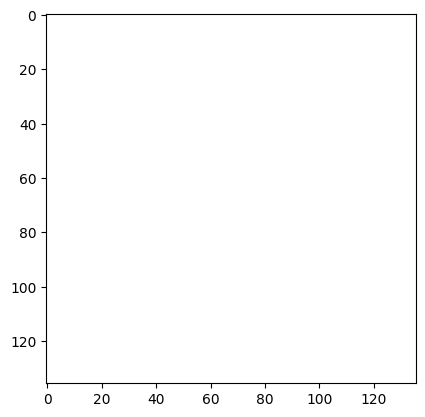

In [27]:
# import matplotlib.animation as animation
# import matplotlib.pyplot as plt

# random_index = 53

# fig = plt.figure()
# imgs = imgs.squeeze()
# ims = []
# for i in range(990):
#     im = plt.imshow(imgs[i], animated=True)
#     ims.append([im])

# animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
# # animate.save('diffusion.gif')
# plt.show()

In [25]:
%pip install -U kaleido
path = "../out/visualized/animation/"
maps = imgs.squeeze().detach().numpy()
# maps = imgs_unnorm.squeeze().detach().numpy()
for i in range(999):
    sampled = maps[i]
    # zero_one_unnorm_sample = pre.zero_one_unnormalize(sampled, diagonal_norm_pseudobulk_1_map.squeeze())
    # sampled = pre.diagonal_unnormalize(zero_one_unnorm_sample, pseudobulk_1_map.detach().numpy().squeeze())
    fig = vis.visualize_contact_map(sampled,zmax=1)
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,)
    fig.update_coloraxes(showscale=False)
    fig.write_image(f"../out/visualized/animation/fig{i}.png")

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [26]:
import imageio

animated = [] 

for i in range(0,1000,20):
    animated.append(imageio.imread(f"../out/visualized/animation/fig{i}.png"))
    
imageio.mimsave('../out/visualized/animated.gif', animated)


/tmp/ipykernel_82517/2993371255.py:6: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



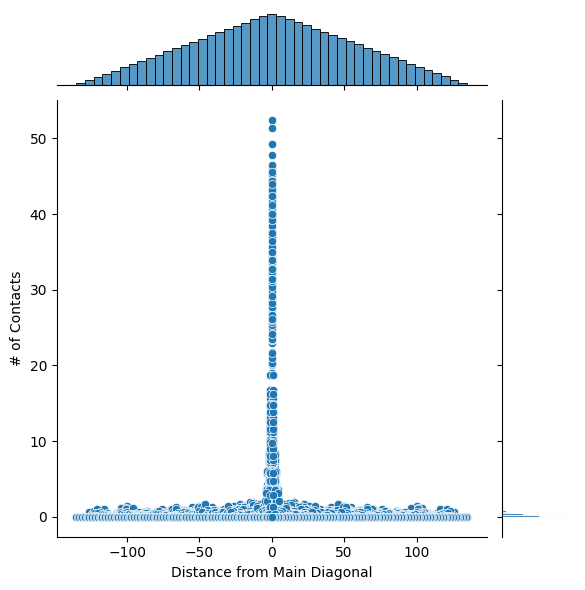

In [21]:
import plotly.figure_factory as ff

def plot_dist_vs_intensity(map):
    distances = []
    intensities = []
    for i in range(len(map)):
        for j in range(len(map[0])):
            # if i > j:
            #     distances.append(i-j)
            # else:
            distances.append(i-j)
            intensities.append(map[i][j])
    df = pd.DataFrame({"Distance from Main Diagonal":distances,"# of Contacts":intensities})
    fig = sns.jointplot(data=df, x="Distance from Main Diagonal", y="# of Contacts")
    return fig
            
plot_dist_vs_intensity(pseudobulk_1_map.detach().numpy().squeeze())